In [2]:
# general imports
import numpy as np
import pandas as pd
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
# visualisation imports
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (10,8)
matplotlib.rcParams.update({'axes.grid': True})
plt.rc('axes',labelsize=(12))
plt.rcParams.update({'font.size': 11})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [5]:
# import historical forecast data
data = pd.read_csv(r'C:\Users\JHIV\OneDrive - Novo Nordisk\Thesis\Model\Data\Data_Input\All_GSF1.csv', sep=',')
data['FiscalDate'] = pd.to_datetime(data['FiscalDate'])

# Data preprocessing and visualisation functions

The following functions are created to ensure the correct formate of the demand forecas, and to plot the forecast, compute the forecast accuracy and visualise the autocorrelation of forecasts 

In [6]:
### Find the time difference between the data of the forecast and the forecasted month
# if diff is nagetive the value is realised demand

def add_timeframe(data):
    data['Version'] = data['Version'].apply(lambda x: datetime.strptime(str(x), '%Y%m'))

    #finding the time difference from version date to forecasted/realised month
    data['diff'] = data.apply(lambda x: relativedelta(x['FiscalDate'], x['Version']).years, axis=1)
    data['diff'] = data['diff']*12 + data.apply(lambda x: relativedelta(x['FiscalDate'], x['Version']).months, axis=1)

    data = data.loc[data['diff'] >= -2]
    data = data.loc[data['diff'] <= 3]
    
    return data

In [7]:
data = add_timeframe(data)

In [8]:
# pivot table to contain a realised demand and forecasted demand for each forcast veriosn

def prepare_Time_series(data, agg_level=None, timeframe= None):
    '''
    Aggragation level should be set to either Country, product or a combination'''
    
    if agg_level == None:
        agg_level == 1
    dict = {1 : ['CountryText','Customer_Id','FiscalDate'], 2: ['Product_id','FiscalDate'], 3: ['CountryText','Customer_Id','Product_id','FiscalDate']}

    if timeframe == None:
        timeframe = 1
    
    df_realised = data.loc[(data['diff']==-2) | (data['diff']==-1)]
    df_realised = pd.pivot_table(df_realised, columns='diff', values='Sum_Volume_U3', aggfunc=np.max, index=['CountryText', 'Customer_Id', 'Product_id', 'FiscalDate']).reset_index()
    df_realised.columns = ['CountryText', 'Customer_Id', 'Product_id', 'FiscalDate','-2','-1']
    df_realised['realised'] = df_realised[['-2','-1']].max(axis=1)
    
    df_forecast = data[data['diff'] == timeframe]
    df_forecast = df_forecast.rename(columns={"Sum_Volume_U3": "forecast"})
    
    df_realised = df_realised.groupby(dict[agg_level]).sum()['realised'].reset_index()
    df_forecast = df_forecast.groupby(dict[agg_level]).sum()['forecast'].reset_index()
    timeseries = df_realised.merge(df_forecast)

    return timeseries

    

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import itertools

# define forecast accuracy measured not in sklearn (MAPE and MAD)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_deviation(y_true, y_pred):
    return (np.sum(y_pred-y_true)/len(y_true))


In [10]:
# compute the forecast accuracy for all product variants

def prediction_measure(df, agg_level = None):

    if agg_level == None:
        agg_level == 1
    dict = {1 : ['CountryText','Customer_Id'], 2: ['Product_id'],3: ['CountryText','Customer_Id','Product_id']}
    
    pred_dict = df.groupby(dict[agg_level])['forecast'].apply(list)
    true_dict = df.groupby(dict[agg_level])['realised'].apply(list)
    index1 = pred_dict.index

    model_scores = []

    for i in range(len(pred_dict)):
        model_metrics = list(pred_dict.index[i])

        y_true = true_dict.loc[index1[i]]
        y_pred = pred_dict.loc[index1[i]]

        avg_r2 = r2_score(y_true,y_pred)
        avg_mae = mean_absolute_error(y_true, y_pred)
        avg_mad = mean_absolute_deviation(np.transpose(y_true), np.transpose(y_pred))
        avg_mape = mean_absolute_percentage_error(np.transpose(y_true), np.transpose(y_pred))

        model_metrics.append(avg_r2)
        model_metrics.append(avg_mae)
        model_metrics.append(avg_mad)
        model_metrics.append(avg_mape)

        model_scores.append(model_metrics)
    
    measure_df = pd.DataFrame(model_scores) 
    column_names = dict[agg_level]+['R2', 'MAE', 'MAD', 'MAPE']
    measure_df.columns = column_names

    return measure_df

In [11]:
# Plot: forecasted and realised demand for selected product variants

def prediction_plot(df, scores, index_1, agg_level=None):

    if agg_level == None:
        agg_level = 1
    agg_dict = {1 : ['CountryText','Customer_Id'], 2: ['Product_id'],3: ['CountryText','Customer_Id','Product_id']}

    fig, axes = plt.subplots(3,2)

    min_timestamp = datetime.timestamp(df.FiscalDate.min())
    min_date =datetime.fromtimestamp(min_timestamp)

    max_timestamp = datetime.timestamp(df.FiscalDate.max())
    max_date =datetime.fromtimestamp(max_timestamp)

    set = index_1.loc[:,agg_dict[agg_level]]
    df = set.merge(df, how='left', on = agg_dict[agg_level])

    y_true = df.groupby(agg_dict[agg_level])['realised'].apply(list)
    pred = df.groupby(agg_dict[agg_level])['forecast'].apply(list)
    date = df.groupby(agg_dict[agg_level])['FiscalDate'].apply(list)
    id = y_true.index
    index_1['Naming'] = index_1['Product_id'].str.split('_').to_list()

    for i, ax in enumerate(axes.flatten()):
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = -30)

        y_t = pd.Series((y_true.loc[id[i]]), index = date.loc[id[i]])
        p_t = pd.Series((pred.loc[id[i]]), index = date.loc[id[i]])

        ax.plot(y_t, label = 'Realised')
        ax.plot(p_t, color='red', ls='--', label= 'Prediction')
        ax.set_ylabel('Demand')
        ax.set_title(f"{id[i][0]}  -  {' '.join(index_1.Naming.values[i][2:])} \n with MAPE {index_1.MAPE.values[i]}")
        ax.legend()
    fig.tight_layout()
    fig.show()
    return  
        

In [12]:
# Plot: correlation between forecast accuracy measures and order volumes

def demand_fa_correlation(df, agg=None):
    ''' 
    plots the correlation between realised demand and forecast accuracy measures
    '''
    if agg == None:
        agg = 'realised'
    fig, axes = plt.subplots(2,2, figsize=(15,8))

    measures = ['R2', 'MAE', 'MAD', 'MAPE']
    demand = ['realised', 'forecast']

    for i, ax in enumerate(axes.flatten()):
        plt.setp(ax.xaxis.get_majorticklabels(), rotation = -30)
        ax.scatter(x=df[measures[i]],y=df[agg], s=50,   color = 'orange', edgecolor='red')
        ax.set_title(f"Correlation of {measures[i]} and the demand {agg}")
        ax.set_ylabel('Reaslied demand')
        
    fig.tight_layout()
    fig.show() 

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot: Autocorrelation and partialautocorrelation for seleted product vairants

def auto_corr(df, index):
    index['Naming'] = index['Product_id'].str.split('_').to_list()
    
    fig, axes = plt.subplots(2, 3, figsize=(10,6))

    for i in range(len(index)):
        data = df[(df['Customer_Id'] == index['Customer_Id'].values[i]) & (df['Product_id']==index['Product_id'].values[i])]
        data = pd.DataFrame(data.groupby('FiscalDate').sum()['realised'])
        plot_acf(data['realised'], ax=axes[0,i])
        plot_pacf(data['realised'], ax=axes[1,i])
        axes[0,i].set_title(f"{index.CountryText.values[i]}  -  {' '.join(index.Naming.values[i][2:])}")
        axes[1,i].set_title(' ')
    axes[0,0].set_ylabel('Autocorrelation')
    axes[1,0].set_ylabel('Partial Autocorrelation')
    
    fig.tight_layout()
    fig.show()

# Visualise the forecast performance

To analyse the general forecast performances the demand forecast and realised demand are visualised for the six countries with the best and worst forecast accuracy according the mean absolute percentage error

In [14]:
# mearuring forecast made 1 month in advance, e.g. forecasted volumes for August, estimated in June
ts = prepare_Time_series(data, 3, 1)
ts = ts[ts['realised']>0]

In [15]:
#finding the performance of all product variants 

df_measures = prediction_measure(ts, 3)
df_measures['R2'] = df_measures['R2'].round(decimals=2)
df_measures['MAE'] = df_measures['MAE'].round(decimals=2)
df_measures['MAD'] = df_measures['MAD'].round(decimals=2)
df_measures['MAPE'] = df_measures['MAPE'].round(decimals=2)
#df_measures['RMSE'] = df_measures['RMSE'].round(decimals=2)

In [15]:
# Save forecast accuracy for all product variants

df_measures.to_excel('Forecast_accuracy_pv.xlsx')

### Forecast performance for the 6 produt vairants with worst MAPE

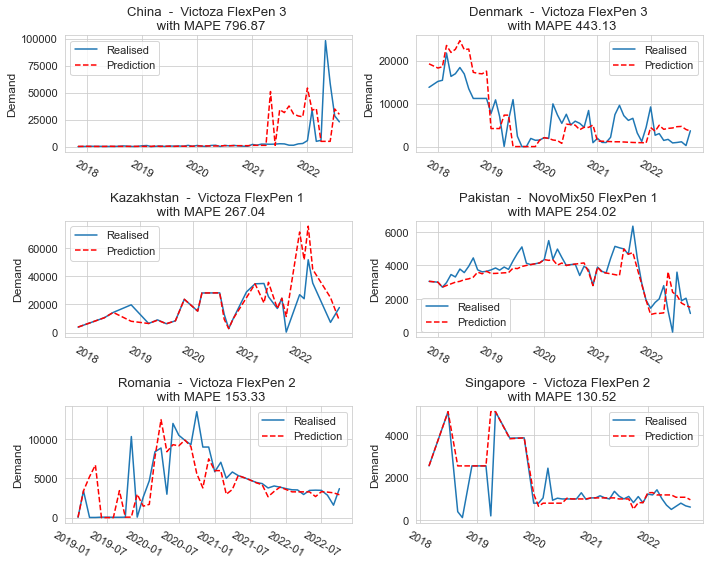

In [21]:
# sort data based on MAPE score, and select 6 worse product variants

worst6 = df_measures.sort_values(by='MAPE', ascending=False).drop_duplicates('MAPE').head(6)
prediction_plot(ts, df_measures, worst6, 3)

### Forecast performance for the 6 produt vairants with best MAPE

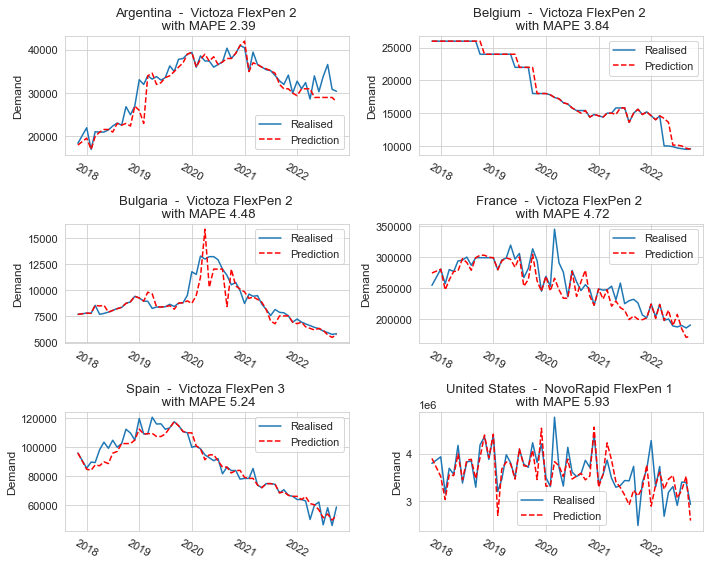

In [22]:
# sort data based on MAPE score, and select 6 best product variants 
 
best6 =  df_measures.sort_values(by='MAPE', ascending=True).drop_duplicates('MAPE').head(6)
prediction_plot(ts, df_measures, best6, 3)

### the 6 product variants with the highest and lowest demand

To analyse whether there is a correlation between order significance and forecast accuracy performance

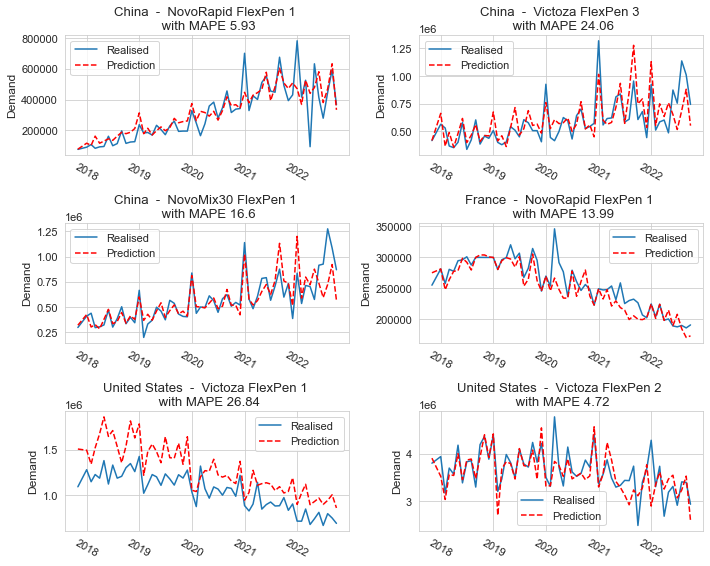

In [23]:
# finding the product vairants with the highest order volumes

realised_sum = ts.groupby(['CountryText','Customer_Id','Product_id']).sum()['realised'].reset_index()
largest6 = realised_sum.sort_values(by = 'realised', ascending=False).drop_duplicates('realised').head(6)
largest6 = largest6.merge(df_measures, how='left', on=['CountryText','Customer_Id','Product_id'])
prediction_plot(ts, df_measures, largest6, 3)

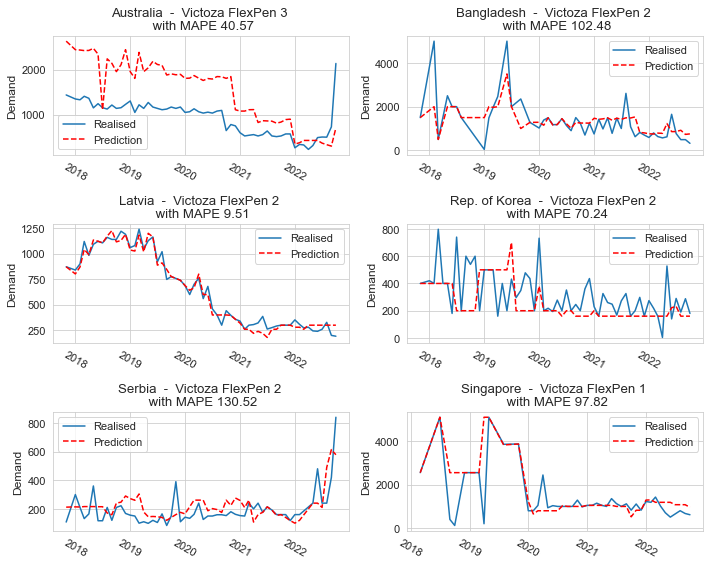

In [24]:
# finding the product vairants with the smallest order volumes

realised_sum = ts.groupby(['CountryText','Customer_Id','Product_id']).sum()['realised'].reset_index()
smallest6 = realised_sum.sort_values(by = 'realised', ascending=True).drop_duplicates('realised').head(6)
smallest6 = smallest6.merge(df_measures, how='left', on=['CountryText','Customer_Id','Product_id'])
prediction_plot(ts, df_measures, smallest6, 3)

### Correlation between forecast accuracy score and demand volumes

To further investigate the correlation between order significance and forecast accuracy performance, 
the correlation for each performance measure are visualised as a scatter plot

In [16]:
# Find the average monthly realised demand of all product variants and 
# visualise it in relation the the 4 forecasst performance measures

volumes = ts.groupby(['Customer_Id','Product_id']).mean()[['realised','forecast']].reset_index()
corr_df = df_measures.merge(volumes, how='left', on=['Customer_Id','Product_id'])
corr_df['ratio'] = corr_df['forecast']/corr_df['realised']

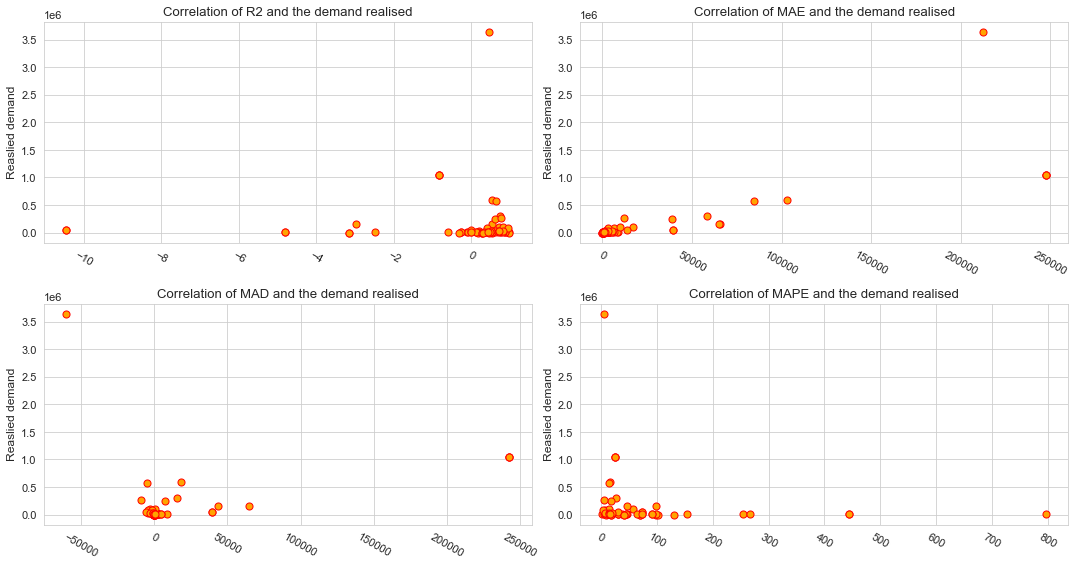

In [17]:
demand_fa_correlation(corr_df, 'realised')

## Autocorrelation and Partial Autocorrelation for the 3 worst and best performing countries

In order to evalute the Bullwhip effect, the autocorrelation and partial autocorrelation are visualised for the best and worst performance product variants according to the MAPE score

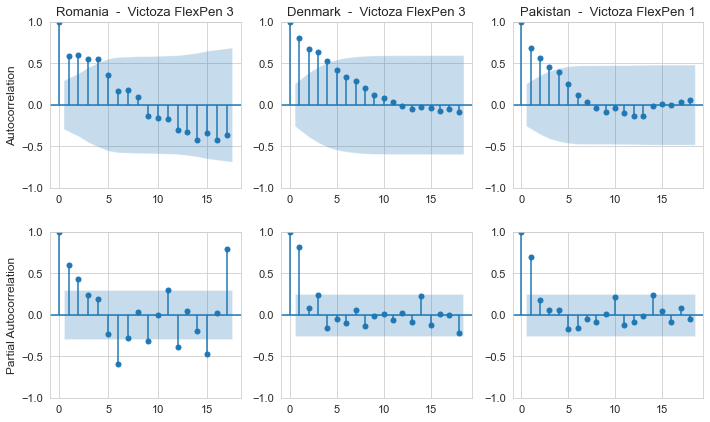

In [22]:
# filtering product variants based on MAPE score, and select the 3 worst 

pca3 = df_measures.sort_values(by='MAPE', ascending=False).drop_duplicates('MAPE').head(3)
auto_corr(ts,pca3)

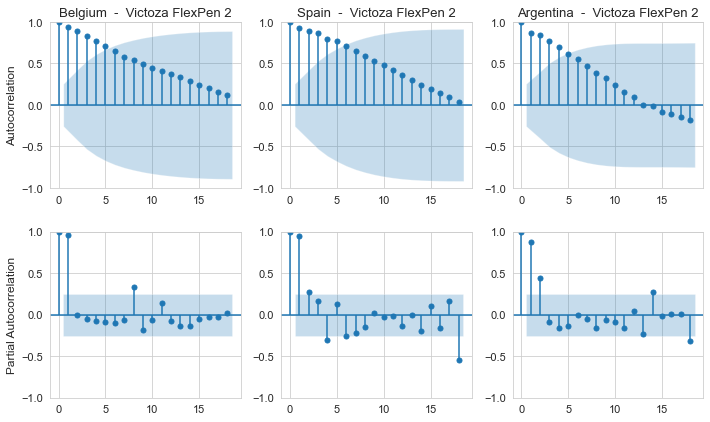

In [24]:
# filtering product variants based on MAPE score, and select the 3 best 

pca3b = df_measures.sort_values(by='MAPE', ascending=True).drop_duplicates('MAPE').head(3)
auto_corr(ts,pca3b)